In [0]:
# feature extractoring and preprocessing data
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [0]:
# def count(X):
#   unique_elements, counts_elements = np.unique(X, return_counts=True)
#   counter = {}
#   for i in range(0,len(unique_elements)):
#     counter[unique_elements[i]] = counts_elements[i]
#   return counter

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/DS/weeplaces/places.data', 'rb') as filehandle:
    # read the data as binary data stream
    places = pickle.load(filehandle)
with open('/content/drive/My Drive/Colab Notebooks/DS/weeplaces/friends.data', 'rb') as filehandle:
    # read the data as binary data stream
    friends = pickle.load(filehandle)
with open('/content/drive/My Drive/Colab Notebooks/DS/weeplaces/friend_count.data', 'rb') as filehandle:
    # read the data as binary data stream
    friend_count = pickle.load(filehandle)
with open('/content/drive/My Drive/Colab Notebooks/DS/weeplaces/friend_visited.data', 'rb') as filehandle:
    # read the data as binary data stream
    friend_visited = pickle.load(filehandle)
with open('/content/drive/My Drive/Colab Notebooks/DS/weeplaces/user_count_list.data', 'rb') as filehandle:
    # read the data as binary data stream
    user_count_list = pickle.load(filehandle)

In [0]:
def count(df):
  counter = {}
  for i in df:
    if i in counter:
      counter[i] += 1
    else:
      counter[i] = 1
  return counter

In [0]:
def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

In [0]:
def get_friendlist(df):
  friends = {}
  index = 0
  for i in df['userid2']:
    if df['userid1'][index] in friends:
      friends[df['userid1'][index]].append(i)
    else:
      friends[df['userid1'][index]] = [i]
    index += 1
  return friends

In [0]:
def get_placelist(df):
  palces = {}
  index = 0
  for i in df['placeid']:
    if df['userid'][index] in palces:
      palces[df['userid'][index]].append(i)
    else:
      palces[df['userid'][index]] = [i]
    index += 1
  return palces

In [0]:
def get_friend_countlist(df):
  friend_count_list = []
  friend_count_list_bianry = []
  for (user,place) in zip(df['userid'],df['placeid']):
    count = 0
    for i in friends[user]:
      try: 
        count += places[i].count(place)
      except KeyError:
        continue
    if count == 0:
      friend_count_list_bianry.append(False)
    else:
      friend_count_list_bianry.append(True)
    friend_count_list.append(count)
  return friend_count_list,friend_count_list_bianry


In [0]:
def get_user_countlist(df):
  user_count_list = []
  for (user,place) in zip(df['userid'],df['placeid']):
    user_count_list.append(places[user].count(place))
  return user_count_list

In [0]:
def get_withfriend_list(df):
  in1 = 1
  withfriend_count_list = {}
  time_more = pd.to_datetime("2010-10-23T00:44:29") - pd.to_datetime("2010-10-23T00:14:29")
  time_less = pd.to_datetime("2010-10-23T00:14:29") - pd.to_datetime("2010-10-23T00:44:29")
  temp_df = df
  for (user,place,user_time) in zip(df['userid'],df['placeid'],df['datetime']):
    if user+" "+place not in withfriend_count_list:
      withfriend_count_list[user+" "+place] = 0
    count = withfriend_count_list[user+" "+place]
    for friend in friends[user]:
      friend_df = temp_df.loc[(temp_df["userid"]==friend) & (temp_df["placeid"]==place)]
      for friend_time in friend_df['datetime']:
        time_check = user_time - friend_time 
        if time_check <= time_more and time_check >= time_less:
          count += 1
    withfriend_count_list[user+" "+place] = count
    temp_df = df
    in1 += 1
  return withfriend_count_list

In [0]:
def get_day_part(df):
  # 4 to 10 Morning
  # 10 to 15 Noon
  # 15 to 20 evening
  # 20 to 5 Night
  mor = 0
  noon = 0
  eve = 0
  night = 0
  output_dict = {}
  for user,place in zip(df['userid'],df['placeid']):
    if (user+" "+place) in output_dict:
      continue
    else:
      temp_df = df.loc[(df['userid']==user)&(df['placeid']==place)]
      for date in temp_df['datetime']:
        # print(date.hour)
        hour = date.hour
        if (hour in range(4,10)):
          mor += 1
        elif (hour in range(10,15)):
          noon += 1
        elif (hour in range(15,20)):
          eve += 1
        else:
          night += 1
      output_dict[user+" "+place] = [mor,noon,eve,night]
      mor = 0
      noon = 0
      eve = 0
      night = 0
  return output_dict

In [3]:
df_checkin = pd.read_csv("/content/drive/My Drive/Colab Notebooks/DS/weeplaces/weeplace_checkins.csv")
df_checkin["datetime"] = pd.to_datetime(df_checkin["datetime"]) 
df_checkin.head()

,userid,placeid,datetime,lat,lon,city,category
0,fred-wilson,tocqueville-new-york,2010-10-22 23:44:29,40.736300,-73.992200,New York,Food:American
1,fred-wilson,wesleyan-university-usdan-university-center-mi...,2010-10-23 17:00:24,41.556974,-72.657571,Middletown,College & Education:Student Center
2,fred-wilson,javapalooza-middletown,2010-10-23 20:30:45,41.558853,-72.648618,Middletown,Food:Coffee Shop
3,fred-wilson,giorgione-new-york,2010-10-24 00:22:49,40.726144,-74.008348,New York,Food:Italian
4,fred-wilson,the-shala-new-york,2010-10-24 16:01:38,40.733075,-73.991478,New York,Home / Work / Other:Gym / Fitness:Yoga Studio


In [0]:
df_friend = pd.read_csv("/content/drive/My Drive/Colab Notebooks/DS/weeplaces/weeplace_friends.csv")
df_friend.head()

,userid1,userid2
0,fred-wilson,justin-shaffer
1,fred-wilson,bijan-sabet
2,fred-wilson,mark-g
3,fred-wilson,ty-white
4,fred-wilson,simon-saint


In [0]:
friends = get_friendlist(df_friend)

In [0]:
places = get_placelist(df_checkin)

In [0]:
user_count_list = get_user_countlist(df_checkin)

In [0]:
len(df_checkin['userid'])

7658368

In [0]:
friend_count, friend_visited = get_friend_countlist(df_checkin)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/DS/weeplaces/user_count_list.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(user_count_list, filehandle)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/DS/weeplaces/friend_count.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(friend_count, filehandle)

In [0]:
df_checkin["datetime"] = pd.to_datetime(df_checkin["datetime"]) 
type(df_checkin["datetime"][0])

pandas._libs.tslibs.timestamps.Timestamp

In [0]:
df_checkin.loc[(df_checkin["userid"]=="fred-wilson") & (df_checkin["placeid"]=="giorgione-new-york")]

,userid,placeid,datetime,lat,lon,city,category
3,fred-wilson,giorgione-new-york,2010-10-24T00:22:49,40.726144,-74.008348,New York,Food:Italian
797,fred-wilson,giorgione-new-york,2010-02-06T01:36:06,40.726144,-74.008348,New York,Food:Italian


In [0]:
temp_df = df_checkin.loc[df_checkin["city"]=='New York']
temp_df.shape

(720350, 7)

In [0]:
temp_df = temp_df.dropna()
temp_df.shape

(694078, 7)

In [0]:
day_part = get_day_part(temp_df)

In [0]:
print(day_part)

None


# Genereting New dataset and apply models

In [0]:
new_df = pd.DataFrame(list(zip(df_checkin["userid"],df_checkin['placeid'],df_checkin["datetime"],df_checkin["lat"],df_checkin["lon"],user_count_list,friend_visited,friend_count,df_checkin['city'])), columns =['userid','placeid','datetime','lat','lon','user_count','friend_visited','friend_count','city']) 

In [55]:
new_df.head()

,userid,placeid,datetime,lat,lon,user_count,friend_visited,friend_count,city
0,fred-wilson,tocqueville-new-york,2010-10-22 23:44:29,40.736300,-73.992200,1,True,1,New York
1,fred-wilson,wesleyan-university-usdan-university-center-mi...,2010-10-23 17:00:24,41.556974,-72.657571,1,False,0,Middletown
2,fred-wilson,javapalooza-middletown,2010-10-23 20:30:45,41.558853,-72.648618,1,False,0,Middletown
3,fred-wilson,giorgione-new-york,2010-10-24 00:22:49,40.726144,-74.008348,2,True,1,New York
4,fred-wilson,the-shala-new-york,2010-10-24 16:01:38,40.733075,-73.991478,4,False,0,New York


In [0]:
new_Df = new_df.dropna()

In [0]:
new_Ddf = new_Df.loc[new_df["city"]=='Queens']
new_Ddf.shape

(17652, 7)

In [0]:
# # temp_df.drop( friend_time.index , inplace=True)
new_Df = new_df.drop_duplicates()

# new_Df = new_Ddf.dropna()
# new_Df = new_Ddf.drop_duplicates()

In [0]:
for i in new_Df['city'].unique(): 
  print(i)
  print(new_Df.loc[new_df["city"]==i].shape)

New York
(720350, 6)
Middletown
(1762, 6)
Brooklyn
(159946, 6)
nan
(0, 6)
Amagansett
(477, 6)
East Hampton
(645, 6)
New york
(1233, 6)
Secaucus
(890, 6)
East Rutherford
(837, 6)
Queens
(17652, 6)
San Francisco
(330975, 6)
Mississauga
(3285, 6)
Toronto
(83065, 6)
Austin
(67687, 6)
Lockhart
(46, 6)
Austin, TX
(58, 6)
East Elmhurst
(2554, 6)
Arlington
(19427, 6)
Washington
(73679, 6)
San Juan
(849, 6)
San juan
(8, 6)
Philadelphia
(42979, 6)
Newark
(8400, 6)
Flushing
(2411, 6)
Edwards
(42, 6)
Avon
(716, 6)
Beaver Creek
(28, 6)
Denver
(29203, 6)
Beaver creek
(1, 6)
Paris
(77632, 6)
Orly
(89, 6)
Cetona
(1, 6)
Rome
(2913, 6)
Roma
(2457, 6)
Fiumicino
(243, 6)
Zurich
(7934, 6)
Luzern
(2207, 6)
Hounslow
(2797, 6)
London
(147610, 6)
Los Angeles
(105251, 6)
Virginia Water
(3, 6)
Soho
(104, 6)
Lisieux
(5, 6)
Port en Bessin
(1, 6)
Deauville
(66, 6)
Westminster
(2878, 6)
Montauk
(901, 6)
Southampton,
(3, 6)
nappeague
(2, 6)
Jamaica
(1613, 6)
Wainscott
(36, 6)
Dublin
(23807, 6)
Scarsdale
(341, 6)
New 

KeyboardInterrupt: ignored

In [0]:
#getting data of particular city.
new_Ddf = new_Df.loc[new_df["city"]=='Queens']
new_Ddf.shape

(17652, 6)

In [0]:
print("No of classes before removing places with less visits:")
print(len(new_Ddf['placeid'].unique()))

No of classes before removing places with less visits:
540


In [0]:
pls_count = {}
for pls in new_Ddf['placeid']:
  if pls in pls_count:
    pls_count[pls] += 1
  else:
    pls_count[pls] = 1

In [0]:
pls_to_rmv = []
for key in list(pls_count.keys()):
  if pls_count[key] < 5:
    pls_to_rmv.append(key)

In [0]:
for pls in pls_to_rmv:
  new_Ddf.drop(new_Ddf[ new_Ddf['placeid'] == pls ].index , inplace=True)
new_Ddf.shape

(17047, 6)

In [0]:
print("No of classes after removing places with less visits:")
print(len(new_Ddf['placeid'].unique()))

No of classes after removing places with less visits:
176


In [0]:
new_Ddf['userid'] = new_Ddf['userid'].astype('category')
new_Ddf['userid'] = new_Ddf['userid'].cat.codes

In [0]:
X = new_Ddf[['userid','user_count','friend_count']]
Y = new_Ddf['placeid']

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

Logistic Regression

In [0]:
lr_clf = LogisticRegression(max_iter=200)
lr_clf.fit(X_train, Y_train)
lr_Y_pred = lr_clf.predict(X_test)

In [0]:
# Logistic Accuracy
print(accuracy_score(Y_test, lr_Y_pred))

0.304594330400782


Decision Tree


In [0]:
#GridSearchCV
dt_gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini','entropy'],
            'splitter' : ['best','random'],
            'max_depth' : [4,5,6,7,8,9,10,11,15,20,30,40,50],
        },
        cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

In [0]:
dt_grid_result = dt_gsc.fit(X_train, Y_train)
dt_best_params = dt_grid_result.best_params_
print(dt_best_params)

{'criterion': 'gini', 'max_depth': 40, 'splitter': 'random'}


In [0]:
dt_clf = DecisionTreeClassifier(criterion = "gini", splitter = 'random', max_depth = 40)
dt_clf.fit(X_train, Y_train)
dt_Y_pred = dt_clf.predict(X_test)

In [0]:
# Decision Tree Accuracy
print(accuracy_score(Y_test, dt_Y_pred))

0.7182795698924731


In [0]:
print(classification_report(y_pred=dt_Y_pred,y_true=Y_test))

Random Forest

In [0]:
rf_gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'n_estimators': [50,100,150,200,250,300,350,400,450,500],
            'criterion': ['gini','entropy'],
        },
        cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

In [0]:
rf_grid_result = rf_gsc.fit(X_train, Y_train)
rf_best_params = rf_grid_result.best_params_
print(rf_best_params)

In [0]:
cv_model = RandomForestClassifier(n_estimators=100, criterion= 'gini',bootstrap = True, max_features = 'sqrt')

In [0]:
cv_clf = cv_model.fit(X_train, Y_train)

In [0]:
Y_pred = cv_clf.predict(X_test)

In [0]:
# Random Forest Accuracy
print(accuracy_score(Y_test, Y_pred))

0.7176930596285435


In [0]:
print(classification_report(y_pred=Y_pred,y_true=Y_test))

# Cluster


In [0]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

In [80]:
temp_df = df_checkin.loc[df_checkin["city"]=='Queens']
temp_df = temp_df.dropna()
X=temp_df.loc[:,['placeid','lat','lon']]
X.head(10)

,placeid,lat,lon
83,john-f-kennedy-international-airport-jfk-queens,40.645122,-73.783493
89,john-f-kennedy-international-airport-jfk-queens,40.645122,-73.783493
135,laguardia-airport-lga-queens,40.774302,-73.871920
141,john-f-kennedy-international-airport-jfk-queens,40.645122,-73.783493
156,john-f-kennedy-international-airport-jfk-queens,40.645122,-73.783493
182,jfk-terminal-5-queens,40.646066,-73.777957
187,jfk-terminal-5-queens,40.646066,-73.777957
514,john-f-kennedy-international-airport-jfk-queens,40.646001,-73.784394
622,john-f-kennedy-international-airport-jfk-queens,40.646001,-73.784394
628,jfk-intl-airport-terminal-2-queens,40.640726,-73.789372


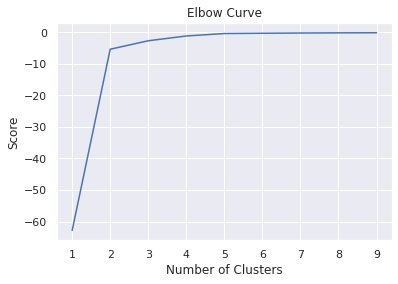

In [81]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = X[['lat']]
X_axis = X[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [84]:
kmeans = KMeans(n_clusters = 2, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) 
# Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ 
# Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) 
# Labels of each point
X.head(10)

,placeid,lat,lon,cluster_label
83,john-f-kennedy-international-airport-jfk-queens,40.645122,-73.783493,1
89,john-f-kennedy-international-airport-jfk-queens,40.645122,-73.783493,1
135,laguardia-airport-lga-queens,40.774302,-73.871920,0
141,john-f-kennedy-international-airport-jfk-queens,40.645122,-73.783493,1
156,john-f-kennedy-international-airport-jfk-queens,40.645122,-73.783493,1
182,jfk-terminal-5-queens,40.646066,-73.777957,1
187,jfk-terminal-5-queens,40.646066,-73.777957,1
514,john-f-kennedy-international-airport-jfk-queens,40.646001,-73.784394,1
622,john-f-kennedy-international-airport-jfk-queens,40.646001,-73.784394,1
628,jfk-intl-airport-terminal-2-queens,40.640726,-73.789372,1


In [85]:
count(labels)

{0: 6805, 1: 10621}

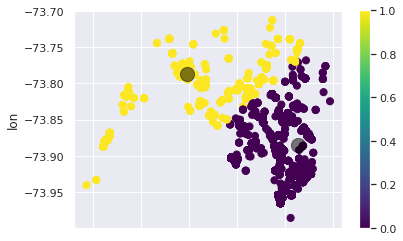

In [86]:
X.plot.scatter(x = 'lat', y = 'lon', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [0]:
df_work = new_df.loc[new_df["city"]=='Queens']
df_work = df_work.dropna()

In [116]:
df_work.head()

,userid,placeid,datetime,lat,lon,user_count,friend_visited,friend_count,city
83,fred-wilson,john-f-kennedy-international-airport-jfk-queens,2010-09-20 10:32:23,40.645122,-73.783493,6,True,157,Queens
89,fred-wilson,john-f-kennedy-international-airport-jfk-queens,2010-09-22 10:37:43,40.645122,-73.783493,6,True,157,Queens
135,fred-wilson,laguardia-airport-lga-queens,2010-10-06 22:36:44,40.774302,-73.871920,2,True,81,Queens
141,fred-wilson,john-f-kennedy-international-airport-jfk-queens,2010-10-08 12:28:25,40.645122,-73.783493,6,True,157,Queens
156,fred-wilson,john-f-kennedy-international-airport-jfk-queens,2010-10-11 20:48:22,40.645122,-73.783493,6,True,157,Queens


In [0]:
day_part = get_day_part(df_work) 

In [0]:
mor = []
noon = []
eve = []
night = []

In [0]:
for user,place in zip(df_work['userid'],df_work['placeid']):
  mor.append(day_part[user+" "+place][0])
  noon.append(day_part[user+" "+place][1])
  eve.append(day_part[user+" "+place][2])
  night.append(day_part[user+" "+place][3])

In [0]:
df_work['morning'] = mor
df_work['noon'] = noon
df_work['evening'] = eve
df_work['night'] = night

In [124]:
label = kmeans.predict(df_work[df_work.columns[3:5]])
count(label)

{0: 6974, 1: 10678}

In [0]:
df_work['cluster_label'] = label

In [0]:
df_work['userid'] = df_work['userid'].astype('category')
df_work['userid'] = df_work['userid'].cat.codes

In [0]:
X = df_work[['user_count','friend_count','morning','noon','evening','night']]
Y = df_work['cluster_label']

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [0]:
dt_gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini','entropy'],
            'splitter' : ['best','random'],
            'max_depth' : [4,5,6,7,8,9,10,11,15,20,30,40,50],
        },
        cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

In [158]:
dt_grid_result = dt_gsc.fit(X_train, Y_train)
dt_best_params = dt_grid_result.best_params_
print(dt_best_params)

{'criterion': 'gini', 'max_depth': 40, 'splitter': 'random'}


In [0]:
dt_clf = DecisionTreeClassifier(criterion = "gini", splitter = 'random', max_depth = 40)
dt_clf.fit(X_train, Y_train)
dt_Y_pred = dt_clf.predict(X_test)

In [161]:
print("Confusion Matrix:\n",confusion_matrix(Y_test, dt_Y_pred))
print(classification_report(dt_Y_pred,Y_test))

Confusion Matrix:
 [[1287  777]
 [ 219 3013]]
              precision    recall  f1-score   support

           0       0.62      0.85      0.72      1506
           1       0.93      0.79      0.86      3790

    accuracy                           0.81      5296
   macro avg       0.78      0.82      0.79      5296
weighted avg       0.84      0.81      0.82      5296

